# TFM-Entrenamiento de los modelos
Alumna: Jone Aguinaga Bengoetxea

Tutora: Yudith Coromoto Cardinale Villarreal

Máster Universitario en Big Data y Ciencia de Datos, VIU

#0.Importar librerias, datasets, crear funciones

In [ ]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from scipy.stats import randint as sp_randint
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, balanced_accuracy_score,
    classification_report, roc_curve, auc
)
from sklearn.decomposition import PCA
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE

from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, ReLU, MaxPooling1D, AveragePooling1D,
    Masking, LSTM, Flatten, Dropout, Dense
)

Carga de tablas

In [ ]:
#Google drive
from google.colab import drive
drive.mount('/content/drive')

#Directorio del dataset
DSet = '/content/drive/MyDrive/TFM/Dataset/midata'
os.chdir(DSet)

print("\nCarpeta actual:\n", os.getcwd())
print("\nArchivos en la carpeta:\n", os.listdir())

Mounted at /content/drive

Carpeta actual:
 /content/drive/MyDrive/TFM/Dataset/midata

Archivos en la carpeta:
 ['y_train.csv', 'id_train.csv', 'y_test.csv', 'y_val.csv', 'id_val.csv', 'id_test.csv', 'x_val_restructured.pkl', 'x_test_restructured.pkl', 'x_train_restructured.pkl', 'x_test_ml.csv', 'x_val_ml.csv', 'x_train_ml.csv', 'modelo_svc.pkl']


In [ ]:
x_train_restructured=pd.read_pickle('x_train_restructured.pkl')
x_val_restructured=pd.read_pickle('x_val_restructured.pkl')
x_test_restructured=pd.read_pickle('x_test_restructured.pkl')

In [ ]:
x_test_restructured.shape

(32759, 3)

In [ ]:
y_train=pd.read_csv('y_train.csv')
y_val=pd.read_csv('y_val.csv')
y_test=pd.read_csv('y_test.csv')

In [ ]:
print(y_train['Label'].value_counts(normalize=True))

Label
0    0.706192
1    0.293808
Name: proportion, dtype: float64


In [ ]:
id_train=pd.read_csv('id_train.csv')
id_val=pd.read_csv('id_val.csv')
id_test=pd.read_csv('id_test.csv')

In [ ]:
x_train_ml=pd.read_csv('x_train_ml.csv')
x_val_ml=pd.read_csv('x_val_ml.csv')
x_test_ml=pd.read_csv('x_test_ml.csv')

Funciones para clasificar como caída.

In [ ]:
def tres_seguidas(predicciones):
  for i in range(len(predicciones)-2):
    if predicciones.iloc[i]==1 and predicciones.iloc[i+1]==1 and predicciones.iloc[i+2]==1:
      return 1
  return 0

In [ ]:
def seis_seguidas(predicciones):
  for i in range(len(predicciones)-5):
    if predicciones.iloc[i]==1 and predicciones.iloc[i+1]==1 and predicciones.iloc[i+2]==1 and predicciones.iloc[i+3]==1 and predicciones.iloc[i+4]==1 and predicciones.iloc[i+5]==1:
      return 1
  return 0

In [ ]:
def ocho_seguidas(predicciones):
  for i in range(len(predicciones)-7):
    if predicciones.iloc[i]==1 and predicciones.iloc[i+1]==1 and predicciones.iloc[i+2]==1 and predicciones.iloc[i+3]==1 and predicciones.iloc[i+4]==1 and predicciones.iloc[i+5]==1 and predicciones.iloc[i+6]==1 and predicciones.iloc[i+7]==1:
      return 1
  return 0

In [ ]:
def diez_seguidas(predicciones):
  for i in range(len(predicciones)-9):
    if predicciones.iloc[i]==1 and predicciones.iloc[i+1]==1 and predicciones.iloc[i+2]==1 and predicciones.iloc[i+3]==1 and predicciones.iloc[i+4]==1 and predicciones.iloc[i+5]==1 and predicciones.iloc[i+6]==1 and predicciones.iloc[i+7]==1 and predicciones.iloc[i+8]==1 and predicciones.iloc[i+9]==1:
      return 1
  return 0

In [ ]:
def doce_seguidas(predicciones):
  for i in range(len(predicciones)-11):
    if predicciones.iloc[i]==1 and predicciones.iloc[i+1]==1 and predicciones.iloc[i+2]==1 and predicciones.iloc[i+3]==1 and predicciones.iloc[i+4]==1 and predicciones.iloc[i+5]==1 and predicciones.iloc[i+6]==1 and predicciones.iloc[i+7]==1 and predicciones.iloc[i+8]==1 and predicciones.iloc[i+9]==1 and predicciones.iloc[i+10]==1 and predicciones.iloc[i+11]==1:
      return 1
  return 0

Función para mostrar los resultados.

In [ ]:
def resultados(y_real, y_pred):
  accuracy = accuracy_score(y_real, y_pred)
  precision = precision_score(y_real, y_pred, average='binary')
  recall = recall_score(y_real, y_pred, average='binary')
  f1 = f1_score(y_real, y_pred, average='binary')

  conf_matrix = confusion_matrix(y_real, y_pred)
  balanced_accuracy = balanced_accuracy_score(y_real, y_pred)
  class_report = classification_report(y_real, y_pred)

  print(f"Accuracy: {accuracy}")
  print(f"Precision: {precision}")
  print(f"Recall: {recall}")
  print(f"F1-score: {f1}")
  print("Confusion Matrix:")
  print(conf_matrix)
  print(f"Balanced Accuracy: {balanced_accuracy}")
  print("Classification Report:")
  print(class_report)

In [ ]:
unique_ids = np.unique(id_test)

In [ ]:
y_test_true=[]
for id in id_test['ID'].unique():
  t_num = int(id.split("T")[1][:2])
  if 20 <= t_num <= 34:
      y_test_true.append(1)
  else:
      y_test_true.append(0)

SMOTE

In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(x_train_ml, y_train)

In [ ]:
X_resampled.shape

(354712, 72)

El dataset es demasiado grande para utilizar el RandomizedSearch y GridSearch, por lo tanto, utilizaremos el únicamente el 5% de los datos para buscar los mejores hiperparámetros.

In [ ]:
X_sample, _, y_sample, _ = train_test_split(X_resampled, y_resampled, test_size=0.95, random_state=42, stratify=y_resampled)

# 1.KNN

In [ ]:
knn_model= KNeighborsClassifier()

RandomizedSearch

In [ ]:
param_dist = {"n_neighbors": [1, 3, 5, 11],
              "weights": ["uniform", "distance"],
              "algorithm": ["auto", "kd_tree"],
              "leaf_size": [ 30, 40],
              "p":[1,2],
              "metric": ["minkowski", "euclidean", "manhattan"]}

In [ ]:
rnd_knn= RandomizedSearchCV(estimator = knn_model, param_distributions = param_dist,
                               n_iter = 50, cv = 4, random_state=0, n_jobs = -1)
rnd_knn.fit(X_sample, y_sample)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


RandomizedSearchCV(cv=4, estimator=KNeighborsClassifier(), n_iter=50, n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'kd_tree'],
                                        'leaf_size': [30, 40],
                                        'metric': ['minkowski', 'euclidean',
                                                   'manhattan'],
                                        'n_neighbors': [1, 3, 5, 11],
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   random_state=0, verbose=1)

In [ ]:
rnd_knn.best_params_

{'weights': 'distance',
 'p': 1,
 'n_neighbors': 3,
 'metric': 'minkowski',
 'leaf_size': 30,
 'algorithm': 'auto'}

GridSearch

In [ ]:
param_dist = {"n_neighbors": [1, 3, 5],
              "weights": ["distance"],
              "algorithm": ["auto"],
              "leaf_size": [ 20,30, 40],
              "p":[1,2],
              "metric": ["minkowski"]}

In [ ]:
grid_knn = GridSearchCV(estimator=knn_model, param_grid=param_dist, cv=4, n_jobs=-1)
grid_knn.fit(X_sample, y_sample)

/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


GridSearchCV(cv=4, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto'], 'leaf_size': [20, 30, 40],
                         'metric': ['minkowski'], 'n_neighbors': [1, 3, 5],
                         'p': [1, 2], 'weights': ['distance']})

In [ ]:
grid_knn.best_estimator_

KNeighborsClassifier(leaf_size=20, n_neighbors=3, p=1, weights='distance')

KNeighborsClassifier(leaf_size=20, n_neighbors=3, p=1, weights='distance')

In [ ]:
knn=KNeighborsClassifier(leaf_size=20, n_neighbors=3, p=1, weights='distance')

Entrenar el modelo.

In [ ]:
knn.fit(X_resampled, y_resampled['Label'])

KNeighborsClassifier(leaf_size=20, n_neighbors=3, p=1, weights='distance')

Predicciones de validación.

In [ ]:
y_pred_val_knn = knn.predict(x_val_ml)

In [ ]:
resultados(y_val, y_pred_val_knn)

Accuracy: 0.9651379350483064
Precision: 0.9128873997846118
Recall: 0.9419681442153353
Confusion Matrix:
[[25537   728]
 [  470  7629]]
Balanced Accuracy: 0.9571253247252195
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     26265
           1       0.91      0.94      0.93      8099

    accuracy                           0.97     34364
   macro avg       0.95      0.96      0.95     34364
weighted avg       0.97      0.97      0.97     34364



Predicciones del test.

In [ ]:
y_pred_knn = knn.predict(x_test_ml)

In [ ]:
resultados(y_test, y_pred_knn)

Accuracy: 0.9575383863976312
Precision: 0.9137143562523146
Recall: 0.9145045712873734
Confusion Matrix:
[[23966   699]
 [  692  7402]]
Balanced Accuracy: 0.9430824093006905
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     24665
           1       0.91      0.91      0.91      8094

    accuracy                           0.96     32759
   macro avg       0.94      0.94      0.94     32759
weighted avg       0.96      0.96      0.96     32759



In [ ]:
id_test["y_pred_knn"] = y_pred_knn

In [ ]:
y_pred_knn_3=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_knn']
  y_pred_knn_3.append(tres_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_knn_3)

Accuracy: 0.9531914893617022
Precision: 0.9079497907949791
Recall: 1.0
Confusion Matrix:
[[231  22]
 [  0 217]]
Balanced Accuracy: 0.9565217391304348
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       253
           1       0.91      1.00      0.95       217

    accuracy                           0.95       470
   macro avg       0.95      0.96      0.95       470
weighted avg       0.96      0.95      0.95       470



In [ ]:
y_pred_knn_6=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_knn']
  y_pred_knn_6.append(seis_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_knn_6)

Accuracy: 0.9872340425531915
Precision: 0.9730941704035875
Recall: 1.0
Confusion Matrix:
[[247   6]
 [  0 217]]
Balanced Accuracy: 0.9881422924901186
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       253
           1       0.97      1.00      0.99       217

    accuracy                           0.99       470
   macro avg       0.99      0.99      0.99       470
weighted avg       0.99      0.99      0.99       470



In [ ]:
y_pred_knn_8=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_knn']
  y_pred_knn_8.append(ocho_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_knn_8)

Accuracy: 0.9893617021276596
Precision: 0.9862385321100917
Recall: 0.9907834101382489
Confusion Matrix:
[[250   3]
 [  2 215]]
Balanced Accuracy: 0.9894628513141837
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       253
           1       0.99      0.99      0.99       217

    accuracy                           0.99       470
   macro avg       0.99      0.99      0.99       470
weighted avg       0.99      0.99      0.99       470



In [ ]:
y_pred_knn_10=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_knn']
  y_pred_knn_10.append(diez_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_knn_10)

Accuracy: 0.9872340425531915
Precision: 0.9861751152073732
Recall: 0.9861751152073732
Confusion Matrix:
[[250   3]
 [  3 214]]
Balanced Accuracy: 0.9871587038487459
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       253
           1       0.99      0.99      0.99       217

    accuracy                           0.99       470
   macro avg       0.99      0.99      0.99       470
weighted avg       0.99      0.99      0.99       470



In [ ]:
y_pred_knn_12=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_knn']
  y_pred_knn_12.append(doce_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_knn_12)

Accuracy: 0.9787234042553191
Precision: 0.9859154929577465
Recall: 0.967741935483871
Confusion Matrix:
[[250   3]
 [  7 210]]
Balanced Accuracy: 0.9779421139869948
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       253
           1       0.99      0.97      0.98       217

    accuracy                           0.98       470
   macro avg       0.98      0.98      0.98       470
weighted avg       0.98      0.98      0.98       470



#2.SVC

Randomized Search

In [ ]:
svc= SVC()

In [ ]:
param_dist = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf", "poly"],
    "gamma": [0.1, 1, 'scale', 'auto'],
    "shrinking": [True, False]
}

In [ ]:
rnd_svc= RandomizedSearchCV(estimator =svc, param_distributions = param_dist, cv=4, n_iter=50, random_state=0, n_jobs = -1)
rnd_svc.fit(X_sample, y_sample)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=4, estimator=SVC(), n_iter=50, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10],
                                        'gamma': [0.1, 1, 'scale', 'auto'],
                                        'kernel': ['linear', 'rbf', 'poly'],
                                        'shrinking': [True, False]},
                   random_state=0)

In [ ]:
rnd_svc.best_params_

{'shrinking': False, 'kernel': 'rbf', 'gamma': 'auto', 'C': 10}


rnd_svc.best_params_
{'shrinking': False, 'kernel': 'rbf', 'gamma': 'auto', 'C': 10}

Grid Search

In [ ]:
param_dist = {
    "C": [5, 10, 50, 100],
    "kernel": ["rbf"],
    "gamma": ['auto'],
    "shrinking": [False]
}

In [ ]:
grid_svc = GridSearchCV(estimator = svc, param_grid= param_dist, cv=4, n_jobs=-1)
grid_svc.fit(X_sample, np.array(y_sample['Label']))

GridSearchCV(cv=4, estimator=SVC(),
             param_grid={'C': [5, 10, 50], 'gamma': ['auto'], 'kernel': ['rbf'],
                         'shrinking': [False]})

In [ ]:
grid_svc.best_estimator_

SVC(C=50, gamma='auto', shrinking=False)

SVC(C=50, gamma='auto', shrinking=False)

In [ ]:
svc = SVC(C=50, gamma='auto', shrinking=False)

In [ ]:
svc.fit(X_resampled, y_resampled['Label'])

SVC(C=50, gamma='auto', shrinking=False)

Realizar las predicciones

Validación

In [ ]:
y_pred_val_svc=svc.predict(x_val_ml)

In [ ]:
resultados(y_val, y_pred_val_svc)

Accuracy: 0.96900826446281
Precision: 0.918192627824019
Recall: 0.9534510433386838
F1-score: 0.9354897328729784
Confusion Matrix:
[[25577   688]
 [  377  7722]]
Balanced Accuracy: 0.963628243923292
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     26265
           1       0.92      0.95      0.94      8099

    accuracy                           0.97     34364
   macro avg       0.95      0.96      0.96     34364
weighted avg       0.97      0.97      0.97     34364



Test

In [ ]:
y_pred_svc=svc.predict(x_test_ml)

In [ ]:
resultados(y_test, y_pred_svc)

Accuracy: 0.9563173479043927
Precision: 0.9002763426649045
Recall: 0.9257474672596986
F1-score: 0.9128342571724432
Confusion Matrix:
[[23835   830]
 [  601  7493]]
Balanced Accuracy: 0.9460482724500399
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     24665
           1       0.90      0.93      0.91      8094

    accuracy                           0.96     32759
   macro avg       0.94      0.95      0.94     32759
weighted avg       0.96      0.96      0.96     32759



In [ ]:
id_test["y_pred_svc"] = y_pred_svc

In [ ]:
y_pred_svc_3=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_svc']
  y_pred_svc_3.append(tres_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_svc_3)

Accuracy: 0.9404255319148936
Precision: 0.8857142857142857
Recall: 1.0
F1-score: 0.9393939393939394
Confusion Matrix:
[[225  28]
 [  0 217]]
Balanced Accuracy: 0.9446640316205533
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94       253
           1       0.89      1.00      0.94       217

    accuracy                           0.94       470
   macro avg       0.94      0.94      0.94       470
weighted avg       0.95      0.94      0.94       470



In [ ]:
y_pred_svc_6=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_svc']
  y_pred_svc_6.append(seis_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_svc_6)

Accuracy: 0.9829787234042553
Precision: 0.9644444444444444
Recall: 1.0
F1-score: 0.9819004524886877
Confusion Matrix:
[[245   8]
 [  0 217]]
Balanced Accuracy: 0.9841897233201581
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       253
           1       0.96      1.00      0.98       217

    accuracy                           0.98       470
   macro avg       0.98      0.98      0.98       470
weighted avg       0.98      0.98      0.98       470



In [ ]:
y_pred_svc_8=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_svc']
  y_pred_svc_8.append(ocho_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_svc_8)

Accuracy: 0.9957446808510638
Precision: 0.9908675799086758
Recall: 1.0
F1-score: 0.9954128440366973
Confusion Matrix:
[[251   2]
 [  0 217]]
Balanced Accuracy: 0.9960474308300395
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       253
           1       0.99      1.00      1.00       217

    accuracy                           1.00       470
   macro avg       1.00      1.00      1.00       470
weighted avg       1.00      1.00      1.00       470



In [ ]:
y_pred_svc_10=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_svc']
  y_pred_svc_10.append(diez_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_svc_10)

Accuracy: 0.9914893617021276
Precision: 0.9907834101382489
Recall: 0.9907834101382489
F1-score: 0.9907834101382489
Confusion Matrix:
[[251   2]
 [  2 215]]
Balanced Accuracy: 0.991439135899164
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       253
           1       0.99      0.99      0.99       217

    accuracy                           0.99       470
   macro avg       0.99      0.99      0.99       470
weighted avg       0.99      0.99      0.99       470



In [ ]:
y_pred_svc_12=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_svc']
  y_pred_svc_12.append(doce_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_svc_12)

Accuracy: 0.9851063829787234
Precision: 0.9952830188679245
Recall: 0.9723502304147466
F1-score: 0.9836829836829837
Confusion Matrix:
[[252   1]
 [  6 211]]
Balanced Accuracy: 0.984198830622393
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       253
           1       1.00      0.97      0.98       217

    accuracy                           0.99       470
   macro avg       0.99      0.98      0.98       470
weighted avg       0.99      0.99      0.99       470



Curva ROC del umbral 8

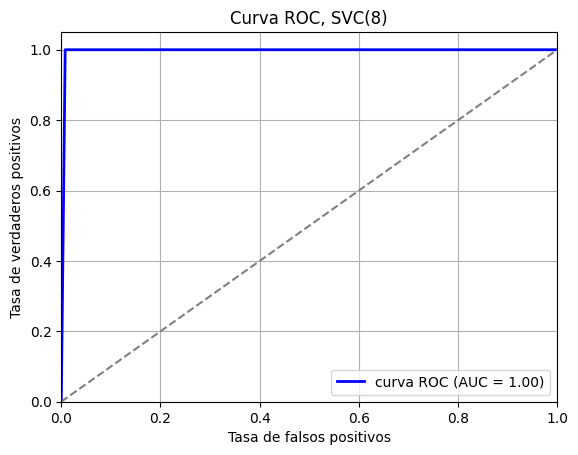

In [ ]:
fpr, tpr, thresholds=roc_curve(y_test_true, y_pred_svc_8)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC, SVC(8)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

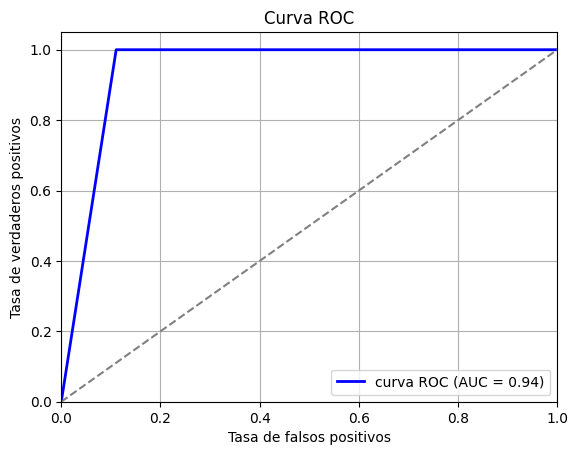

In [ ]:
fpr, tpr, thresholds=roc_curve(y_test_true, y_pred_svc_3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC, SVC(3)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 3.Random Forest

In [ ]:
RF =  RandomForestRegressor()

RandomizedSearch

In [ ]:
param_dist = {"n_estimators": [4, 16, 32],
              "max_features": [1.0, "sqrt"],
              "max_depth": [16, 12, 4, 2,None],
              "min_samples_split": sp_randint(2, 30),
              "min_samples_leaf": sp_randint(1, 30),
              "bootstrap": [True, False],
              "criterion": ["squared_error", "absolute_error"]}

In [ ]:
rnd_rf = RandomizedSearchCV(estimator = RF, param_distributions = param_dist, n_iter = 50, cv = 4, random_state=0, n_jobs = -1)
rnd_rf.fit(X_sample, y_sample)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomizedSearchCV(cv=4, estimator=RandomForestRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['squared_error',
                                                      'absolute_error'],
                                        'max_depth': [16, 12, 4, 2, None],
                                        'max_features': [1.0, 'sqrt'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e0c58888fd0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e0c62146dd0>,
                                        'n_estimators': [4, 16, 32]},
                   random_state=0)

In [ ]:
rnd_rf.best_params_

{'bootstrap': True,
 'criterion': 'squared_error',
 'max_depth': 12,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'min_samples_split': 11,
 'n_estimators': 32}

{'bootstrap': True,
 'criterion': 'squared_error',
 'max_depth': 12,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'min_samples_split': 11,
 'n_estimators': 32}

GridSearch

In [ ]:
param_dist = {"n_estimators": [25, 32, 50],
              "max_features": ['sqrt'],
              "max_depth": [14, 12, 8],
              "min_samples_split": [5, 11, 20],
              "min_samples_leaf": [1 ,5, 10] ,
              "bootstrap": [True],
              "criterion": ["squared_error"]}

In [ ]:
grid_rf = GridSearchCV(estimator = RF, param_grid= param_dist, cv=4, n_jobs=-1)
grid_rf.fit(X_sample, np.array(y_sample['Label']))

GridSearchCV(cv=4, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'criterion': ['squared_error'],
                         'max_depth': [14, 12, 8], 'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [5, 11, 20],
                         'n_estimators': [25, 32, 50]})

In [ ]:
grid_rf.best_params_

{'bootstrap': True,
 'criterion': 'squared_error',
 'max_depth': 14,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 50}

{'bootstrap': True,
 'criterion': 'squared_error',
 'max_depth': 14,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 50}

Entrenar el modelo.

In [ ]:
rf=RandomForestRegressor(n_estimators=50, max_features='sqrt', max_depth= 14, min_samples_split= 5, min_samples_leaf= 1, bootstrap= True, criterion='squared_error')
rf.fit(X_resampled, y_resampled['Label'])

RandomForestRegressor(max_depth=14, max_features='sqrt', min_samples_split=5,
                      n_estimators=50)

Predicciones de la validación.

In [ ]:
y_pred_val_rf=(rf.predict(x_val_ml) > 0.5).astype("int32").ravel()
resultados(y_val, y_pred_val_rf)

Accuracy: 0.9727621929926668
Precision: 0.916695753344968
Recall: 0.9728361526114335
F1-score: 0.943931951599377
Confusion Matrix:
[[25549   716]
 [  220  7879]]
Balanced Accuracy: 0.9727877698141881
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     26265
           1       0.92      0.97      0.94      8099

    accuracy                           0.97     34364
   macro avg       0.95      0.97      0.96     34364
weighted avg       0.97      0.97      0.97     34364



Predicciones del test.

In [ ]:
y_pred_rf=(rf.predict(x_test_ml) > 0.5).astype("int32").ravel()
resultados(y_test, y_pred_rf)

Accuracy: 0.9528679141609939
Precision: 0.8716522923286427
Recall: 0.9489745490486781
F1-score: 0.9086714775819236
Confusion Matrix:
[[23534  1131]
 [  413  7681]]
Balanced Accuracy: 0.9515600497118517
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97     24665
           1       0.87      0.95      0.91      8094

    accuracy                           0.95     32759
   macro avg       0.93      0.95      0.94     32759
weighted avg       0.96      0.95      0.95     32759



In [ ]:
id_test["y_pred_rf"] = y_pred_rf

In [ ]:
y_pred_rf_3=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_rf']
  y_pred_rf_3.append(tres_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_rf_3)

Accuracy: 0.9148936170212766
Precision: 0.8443579766536965
Recall: 1.0
F1-score: 0.9156118143459916
Confusion Matrix:
[[213  40]
 [  0 217]]
Balanced Accuracy: 0.9209486166007905
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.84      0.91       253
           1       0.84      1.00      0.92       217

    accuracy                           0.91       470
   macro avg       0.92      0.92      0.91       470
weighted avg       0.93      0.91      0.91       470



In [ ]:
y_pred_rf_6=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_rf']
  y_pred_rf_6.append(seis_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_rf_6)

Accuracy: 0.9531914893617022
Precision: 0.9079497907949791
Recall: 1.0
F1-score: 0.9517543859649122
Confusion Matrix:
[[231  22]
 [  0 217]]
Balanced Accuracy: 0.9565217391304348
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       253
           1       0.91      1.00      0.95       217

    accuracy                           0.95       470
   macro avg       0.95      0.96      0.95       470
weighted avg       0.96      0.95      0.95       470



In [ ]:
y_pred_rf_8=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_rf']
  y_pred_rf_8.append(ocho_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_rf_8)

Accuracy: 0.9723404255319149
Precision: 0.9434782608695652
Recall: 1.0
F1-score: 0.970917225950783
Confusion Matrix:
[[240  13]
 [  0 217]]
Balanced Accuracy: 0.9743083003952568
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       253
           1       0.94      1.00      0.97       217

    accuracy                           0.97       470
   macro avg       0.97      0.97      0.97       470
weighted avg       0.97      0.97      0.97       470



In [ ]:
y_pred_rf_10=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_rf']
  y_pred_rf_10.append(diez_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_rf_10)

Accuracy: 0.9808510638297873
Precision: 0.9684684684684685
Recall: 0.9907834101382489
F1-score: 0.979498861047836
Confusion Matrix:
[[246   7]
 [  2 215]]
Balanced Accuracy: 0.9815577129742628
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       253
           1       0.97      0.99      0.98       217

    accuracy                           0.98       470
   macro avg       0.98      0.98      0.98       470
weighted avg       0.98      0.98      0.98       470



In [ ]:
y_pred_rf_12=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_rf']
  y_pred_rf_12.append(doce_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_rf_12)

Accuracy: 0.9787234042553191
Precision: 0.9683257918552036
Recall: 0.9861751152073732
F1-score: 0.9771689497716894
Confusion Matrix:
[[246   7]
 [  3 214]]
Balanced Accuracy: 0.979253565508825
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       253
           1       0.97      0.99      0.98       217

    accuracy                           0.98       470
   macro avg       0.98      0.98      0.98       470
weighted avg       0.98      0.98      0.98       470



# 4.LSTM

Reestructuramos los datos.

In [ ]:
x_train = []

for i, row in x_train_restructured.iterrows():
    acc = np.array(row['Acc'])
    gyro = np.array(row['Gyro'])
    euler = np.array(row['Euler'])

    combined = np.concatenate([acc, gyro, euler], axis=1)
    x_train.append(combined)

x_train = np.array(x_train)
print(x_train.shape)

(251144, 50, 9)


In [ ]:
x_val = []

for i, row in x_val_restructured.iterrows():
    acc = np.array(row['Acc'])
    gyro = np.array(row['Gyro'])
    euler = np.array(row['Euler'])

    combined = np.concatenate([acc, gyro, euler], axis=1)
    x_val.append(combined)

x_val = np.array(x_val)
print(x_val.shape)

(34364, 50, 9)


In [ ]:
x_test = []

for i, row in x_test_restructured.iterrows():
    acc = np.array(row['Acc'])
    gyro = np.array(row['Gyro'])
    euler = np.array(row['Euler'])

    combined = np.concatenate([acc, gyro, euler], axis=1)
    x_test.append(combined)

x_test = np.array(x_test)
print(x_test.shape)

(32759, 50, 9)


In [ ]:
y_train=np.array(y_train['Label'])
y_val=np.array(y_val['Label'])
y_test=np.array(y_test['Label'])

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

In [ ]:
# Crear el modelo LSTM
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(50, 9)))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con pesos de clase
LSTM_history=model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val), class_weight=class_weights)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
7849/7849 ━━━━━━━━━━━━━━━━━━━━ 398s 50ms/step - accuracy: 0.9468 - loss: 0.1365 - val_accuracy: 0.9616 - val_loss: 0.0920
Epoch 2/10
7849/7849 ━━━━━━━━━━━━━━━━━━━━ 440s 50ms/step - accuracy: 0.9700 - loss: 0.0737 - val_accuracy: 0.9638 - val_loss: 0.1004
Epoch 3/10
7849/7849 ━━━━━━━━━━━━━━━━━━━━ 441s 50ms/step - accuracy: 0.9744 - loss: 0.0625 - val_accuracy: 0.9775 - val_loss: 0.0677
Epoch 4/10
7849/7849 ━━━━━━━━━━━━━━━━━━━━ 437s 49ms/step - accuracy: 0.9799 - loss: 0.0533 - val_accuracy: 0.9659 - val_loss: 0.1312
Epoch 5/10
7849/7849 ━━━━━━━━━━━━━━━━━━━━ 447s 50ms/step - accuracy: 0.9821 - loss: 0.0447 - val_accuracy: 0.9724 - val_loss: 0.0896
Epoch 6/10
7849/7849 ━━━━━━━━━━━━━━━━━━━━ 436s 49ms/step - accuracy: 0.9840 - loss: 0.0411 - val_accuracy: 0.9838 - val_loss: 0.0701
Epoch 7/10
7849/7849 ━━━━━━━━━━━━━━━━━━━━ 450s 50ms/step - accuracy: 0.9856 - loss: 0.0380 - val_accuracy: 0.9695 - val_loss: 0.0974
Epoch 8/10
7849/7849 ━━━━━━━━━━━━━━━━━━━━ 441s 50ms/step - accuracy: 

Predicciones de validación

In [ ]:
y_pred_val_lstm=(model.predict(x_val) > 0.5).astype("int32").ravel()

1074/1074 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step


In [ ]:
resultados(y_val, y_pred_val_lstm)

Predicciones de test

In [ ]:
y_pred_lstm=(model.predict(x_test) > 0.5).astype("int32").ravel()

1024/1024 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step


In [ ]:
resultados(y_test, y_pred_lstm)

In [ ]:
id_test["y_pred_lstm"] = y_pred_lstm

In [ ]:
y_pred_lstm_3=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_lstm']
  y_pred_lstm_3.append(tres_seguidas(y_id))
  t_num = int(id.split("T")[1][:2])

In [ ]:
resultados(y_test_true, y_pred_lstm_3)

Accuracy: 0.9276595744680851
Precision: 0.8674698795180723
Recall: 0.9953917050691244
F1-score: 0.927038626609442
Confusion Matrix:
[[220  33]
 [  1 216]]
Balanced Accuracy: 0.9324784612302144
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93       253
           1       0.87      1.00      0.93       217

    accuracy                           0.93       470
   macro avg       0.93      0.93      0.93       470
weighted avg       0.94      0.93      0.93       470



In [ ]:
y_pred_lstm_6=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_lstm']
  y_pred_lstm_6.append(seis_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_lstm_6)

Accuracy: 0.9617021276595744
Precision: 0.927038626609442
Recall: 0.9953917050691244
F1-score: 0.96
Confusion Matrix:
[[236  17]
 [  1 216]]
Balanced Accuracy: 0.9640990145898982
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       253
           1       0.93      1.00      0.96       217

    accuracy                           0.96       470
   macro avg       0.96      0.96      0.96       470
weighted avg       0.96      0.96      0.96       470



In [ ]:
y_pred_lstm_8=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_lstm']
  y_pred_lstm_8.append(ocho_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_lstm_8)

Accuracy: 0.9723404255319149
Precision: 0.9553571428571429
Recall: 0.9861751152073732
F1-score: 0.9705215419501134
Confusion Matrix:
[[243  10]
 [  3 214]]
Balanced Accuracy: 0.9733247117538842
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       253
           1       0.96      0.99      0.97       217

    accuracy                           0.97       470
   macro avg       0.97      0.97      0.97       470
weighted avg       0.97      0.97      0.97       470



In [ ]:
y_pred_lstm_10=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_lstm']
  y_pred_lstm_10.append(diez_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_lstm_10)

Accuracy: 0.9765957446808511
Precision: 0.9768518518518519
Recall: 0.9723502304147466
F1-score: 0.9745958429561201
Confusion Matrix:
[[248   5]
 [  6 211]]
Balanced Accuracy: 0.9762936922824721
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       253
           1       0.98      0.97      0.97       217

    accuracy                           0.98       470
   macro avg       0.98      0.98      0.98       470
weighted avg       0.98      0.98      0.98       470



In [ ]:
y_pred_lstm_12=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_lstm']
  y_pred_lstm_12.append(doce_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_lstm_12)

Accuracy: 0.9723404255319149
Precision: 0.9811320754716981
Recall: 0.9585253456221198
F1-score: 0.9696969696969697
Confusion Matrix:
[[249   4]
 [  9 208]]
Balanced Accuracy: 0.9713575344711389
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       253
           1       0.98      0.96      0.97       217

    accuracy                           0.97       470
   macro avg       0.97      0.97      0.97       470
weighted avg       0.97      0.97      0.97       470



Curva ROC

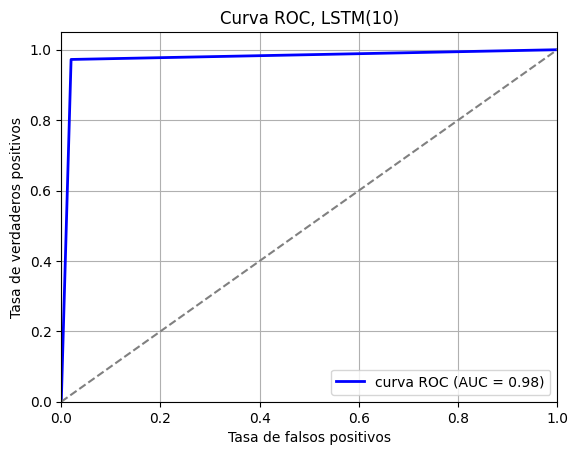

In [ ]:
fpr, tpr, thresholds=roc_curve(y_test_true, y_pred_lstm_10)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC, LSTM(10)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 5.ConvLSTM

In [ ]:
x_train.shape

(251144, 50, 9)

In [ ]:
input_layer = Input(shape=(50, 9))

# Bloque conv1
x = Conv1D(filters=64, kernel_size=6, padding='valid')(input_layer)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling1D(pool_size=2)(x)  # (50 → 22)

# Bloque conv2
x = Conv1D(filters=64, kernel_size=6, padding='valid')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling1D(pool_size=2)(x)  # (22 → 8)

# Bloque conv3
x = Conv1D(filters=64, kernel_size=4, padding='valid')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling1D(pool_size=4)(x)

# Capas LSTM (ahora sí tiene secuencia: 4 pasos)
x = LSTM(64, return_sequences=True)(x)
x = Dropout(0.3)(x)
x = LSTM(64)(x)
x = Dropout(0.3)(x)

# Capa de salida binaria
output = Dense(1, activation='sigmoid')(x)

# Modelo final
model = Model(inputs=input_layer, outputs=output)

# Compilar modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Resumen
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 50, 9)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 45, 64)         │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 45, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 45, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 22, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 17, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 17, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 17, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 5, 64)          │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 5, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,489 (435.50 KB)

 Trainable params: 111,105 (434.00 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
ConvLSTM=model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val), class_weight=class_weights)

Epoch 1/10
7849/7849 ━━━━━━━━━━━━━━━━━━━━ 136s 17ms/step - accuracy: 0.9358 - loss: 0.1727 - val_accuracy: 0.9665 - val_loss: 0.0826
Epoch 2/10
7849/7849 ━━━━━━━━━━━━━━━━━━━━ 147s 17ms/step - accuracy: 0.9608 - loss: 0.1036 - val_accuracy: 0.9662 - val_loss: 0.0797
Epoch 3/10
7849/7849 ━━━━━━━━━━━━━━━━━━━━ 136s 16ms/step - accuracy: 0.9655 - loss: 0.0896 - val_accuracy: 0.9692 - val_loss: 0.0757
Epoch 4/10
7849/7849 ━━━━━━━━━━━━━━━━━━━━ 132s 17ms/step - accuracy: 0.9681 - loss: 0.0808 - val_accuracy: 0.9683 - val_loss: 0.0707
Epoch 5/10
7849/7849 ━━━━━━━━━━━━━━━━━━━━ 143s 17ms/step - accuracy: 0.9693 - loss: 0.0762 - val_accuracy: 0.9700 - val_loss: 0.0823
Epoch 6/10
7849/7849 ━━━━━━━━━━━━━━━━━━━━ 138s 17ms/step - accuracy: 0.9714 - loss: 0.0703 - val_accuracy: 0.9737 - val_loss: 0.0641
Epoch 7/10
7849/7849 ━━━━━━━━━━━━━━━━━━━━ 143s 17ms/step - accuracy: 0.9720 - loss: 0.0682 - val_accuracy: 0.9708 - val_loss: 0.0782
Epoch 8/10
7849/7849 ━━━━━━━━━━━━━━━━━━━━ 142s 17ms/step - accuracy: 

Predicciones de validación

In [ ]:
y_pred_val_convlstm=(model.predict(x_val) > 0.5).astype("int32").ravel()

1074/1074 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step


In [ ]:
resultados(y_val, y_pred_val_convlstm)

Accuracy: 0.9681061576067979
Precision: 0.9143296651283872
Recall: 0.9540684035066057
Confusion Matrix:
[[25541   724]
 [  372  7727]]
Balanced Accuracy: 0.9632516013344945
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     26265
           1       0.91      0.95      0.93      8099

    accuracy                           0.97     34364
   macro avg       0.95      0.96      0.96     34364
weighted avg       0.97      0.97      0.97     34364



Predicciones de test

In [ ]:
y_pred_convlstm=(model.predict(x_test) > 0.5).astype("int32").ravel()

1024/1024 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


In [ ]:
resultados(y_test, y_pred_convlstm)

Accuracy: 0.9629109557678805
Precision: 0.93280483201208
Recall: 0.9158636026686434
Confusion Matrix:
[[24131   534]
 [  681  7413]]
Balanced Accuracy: 0.9471067455873118
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     24665
           1       0.93      0.92      0.92      8094

    accuracy                           0.96     32759
   macro avg       0.95      0.95      0.95     32759
weighted avg       0.96      0.96      0.96     32759



In [ ]:
id_test["y_pred_convlstm"] = y_pred_convlstm

In [ ]:
y_pred_convlstm_3=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_convlstm']
  y_pred_convlstm_3.append(tres_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_convlstm_3)

Accuracy: 0.948936170212766
Precision: 0.9004149377593361
Recall: 1.0
Confusion Matrix:
[[229  24]
 [  0 217]]
Balanced Accuracy: 0.9525691699604744
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       253
           1       0.90      1.00      0.95       217

    accuracy                           0.95       470
   macro avg       0.95      0.95      0.95       470
weighted avg       0.95      0.95      0.95       470



In [ ]:
y_pred_convlstm_6=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_convlstm']
  y_pred_convlstm_6.append(seis_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_convlstm_6)

Accuracy: 0.9808510638297873
Precision: 0.9601769911504425
Recall: 1.0
Confusion Matrix:
[[244   9]
 [  0 217]]
Balanced Accuracy: 0.9822134387351779
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       253
           1       0.96      1.00      0.98       217

    accuracy                           0.98       470
   macro avg       0.98      0.98      0.98       470
weighted avg       0.98      0.98      0.98       470



In [ ]:
y_pred_convlstm_8=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_convlstm']
  y_pred_convlstm_8.append(ocho_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_convlstm_8)

Accuracy: 0.9829787234042553
Precision: 0.9644444444444444
Recall: 1.0
Confusion Matrix:
[[245   8]
 [  0 217]]
Balanced Accuracy: 0.9841897233201581
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       253
           1       0.96      1.00      0.98       217

    accuracy                           0.98       470
   macro avg       0.98      0.98      0.98       470
weighted avg       0.98      0.98      0.98       470



In [ ]:
y_pred_convlstm_10=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_convlstm']
  y_pred_convlstm_10.append(diez_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_convlstm_10)

Accuracy: 0.9765957446808511
Precision: 0.9681818181818181
Recall: 0.9815668202764977
Confusion Matrix:
[[246   7]
 [  4 213]]
Balanced Accuracy: 0.9769494180433872
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       253
           1       0.97      0.98      0.97       217

    accuracy                           0.98       470
   macro avg       0.98      0.98      0.98       470
weighted avg       0.98      0.98      0.98       470



In [ ]:
y_pred_convlstm_12=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_convlstm']
  y_pred_convlstm_12.append(doce_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_convlstm_12)

Accuracy: 0.9765957446808511
Precision: 0.9813084112149533
Recall: 0.967741935483871
Confusion Matrix:
[[249   4]
 [  7 210]]
Balanced Accuracy: 0.9759658294020146
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       253
           1       0.98      0.97      0.97       217

    accuracy                           0.98       470
   macro avg       0.98      0.98      0.98       470
weighted avg       0.98      0.98      0.98       470



# 6.CNN

In [ ]:
input_layer = Input(shape=(50, 9))

In [ ]:
model = Sequential()
model.add(input_layer)

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(AveragePooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(AveragePooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(AveragePooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/10
7849/7849 ━━━━━━━━━━━━━━━━━━━━ 116s 14ms/step - accuracy: 0.9521 - loss: 0.1287 - val_accuracy: 0.9642 - val_loss: 0.0940
Epoch 2/10
7849/7849 ━━━━━━━━━━━━━━━━━━━━ 142s 14ms/step - accuracy: 0.9721 - loss: 0.0723 - val_accuracy: 0.9709 - val_loss: 0.0707
Epoch 3/10
7849/7849 ━━━━━━━━━━━━━━━━━━━━ 142s 14ms/step - accuracy: 0.9781 - loss: 0.0563 - val_accuracy: 0.9644 - val_loss: 0.0821
Epoch 4/10
7849/7849 ━━━━━━━━━━━━━━━━━━━━ 141s 14ms/step - accuracy: 0.9819 - loss: 0.0482 - val_accuracy: 0.9741 - val_loss: 0.0729
Epoch 5/10
7849/7849 ━━━━━━━━━━━━━━━━━━━━ 143s 14ms/step - accuracy: 0.9833 - loss: 0.0440 - val_accuracy: 0.9615 - val_loss: 0.1247
Epoch 6/10
7849/7849 ━━━━━━━━━━━━━━━━━━━━ 145s 15ms/step - accuracy: 0.9843 - loss: 0.0422 - val_accuracy: 0.9777 - val_loss: 0.0665
Epoch 7/10
7849/7849 ━━━━━━━━━━━━━━━━━━━━ 137s 14ms/step - accuracy: 0.9857 - loss: 0.0375 - val_accuracy: 0.9687 - val_loss: 0.1352
Epoch 8/10
7849/7849 ━━━━━━━━━━━━━━━━━━━━ 111s 14ms/step - accuracy: 

Predicciones de validación

In [ ]:
y_pred_val_cnn=(model.predict(x_val) > 0.5).astype("int32").ravel()

1074/1074 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step


In [ ]:
resultados(y_val, y_pred_val_cnn)

Accuracy: 0.9667384472121988
Precision: 0.928430647942843
Recall: 0.930608717125571
Confusion Matrix:
[[25684   581]
 [  562  7537]]
Balanced Accuracy: 0.9542440120941009
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     26265
           1       0.93      0.93      0.93      8099

    accuracy                           0.97     34364
   macro avg       0.95      0.95      0.95     34364
weighted avg       0.97      0.97      0.97     34364



Predicciones de test.

In [ ]:
y_pred_cnn=(model.predict(x_test) > 0.5).astype("int32").ravel()

1024/1024 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


In [ ]:
resultados(y_test, y_pred_cnn)

Accuracy: 0.9428553985164382
Precision: 0.8816241413150148
Recall: 0.8879416851989128
Confusion Matrix:
[[23700   965]
 [  907  7187]]
Balanced Accuracy: 0.924408710022931
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     24665
           1       0.88      0.89      0.88      8094

    accuracy                           0.94     32759
   macro avg       0.92      0.92      0.92     32759
weighted avg       0.94      0.94      0.94     32759



In [ ]:
id_test["y_pred_cnn"] = y_pred_cnn

In [ ]:
y_pred_cnn_3=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_cnn']
  y_pred_cnn_3.append(tres_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_cnn_3)

Accuracy: 0.9702127659574468
Precision: 0.9393939393939394
Recall: 1.0
Confusion Matrix:
[[239  14]
 [  0 217]]
Balanced Accuracy: 0.9723320158102766
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       253
           1       0.94      1.00      0.97       217

    accuracy                           0.97       470
   macro avg       0.97      0.97      0.97       470
weighted avg       0.97      0.97      0.97       470



In [ ]:
y_pred_cnn_6=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_cnn']
  y_pred_cnn_6.append(seis_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_cnn_6)

Accuracy: 0.9872340425531915
Precision: 0.9730941704035875
Recall: 1.0
Confusion Matrix:
[[247   6]
 [  0 217]]
Balanced Accuracy: 0.9881422924901186
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       253
           1       0.97      1.00      0.99       217

    accuracy                           0.99       470
   macro avg       0.99      0.99      0.99       470
weighted avg       0.99      0.99      0.99       470



In [ ]:
y_pred_cnn_8=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_cnn']
  y_pred_cnn_8.append(ocho_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_cnn_8)

Accuracy: 0.9851063829787234
Precision: 0.9772727272727273
Recall: 0.9907834101382489
Confusion Matrix:
[[248   5]
 [  2 215]]
Balanced Accuracy: 0.9855102821442232
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       253
           1       0.98      0.99      0.98       217

    accuracy                           0.99       470
   macro avg       0.98      0.99      0.99       470
weighted avg       0.99      0.99      0.99       470



In [ ]:
y_pred_cnn_10=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_cnn']
  y_pred_cnn_10.append(diez_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_cnn_10)

Accuracy: 0.9744680851063829
Precision: 0.9767441860465116
Recall: 0.967741935483871
Confusion Matrix:
[[248   5]
 [  7 210]]
Balanced Accuracy: 0.9739895448170344
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       253
           1       0.98      0.97      0.97       217

    accuracy                           0.97       470
   macro avg       0.97      0.97      0.97       470
weighted avg       0.97      0.97      0.97       470



In [ ]:
y_pred_cnn_12=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_cnn']
  y_pred_cnn_12.append(doce_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_cnn_12)

Accuracy: 0.9617021276595744
Precision: 0.9760765550239234
Recall: 0.9400921658986175
Confusion Matrix:
[[248   5]
 [ 13 204]]
Balanced Accuracy: 0.9601646600244076
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       253
           1       0.98      0.94      0.96       217

    accuracy                           0.96       470
   macro avg       0.96      0.96      0.96       470
weighted avg       0.96      0.96      0.96       470



# 7.Reducción de la dimensionalidad

(354712, 72)
[0.38076336 0.4821889  0.53723838 0.59020829 0.6389219  0.67354024
 0.70464757 0.73183479 0.75368894 0.77441462 0.79473175 0.81438134
 0.83256066 0.85031378 0.86548404 0.8798236  0.89289774 0.90501825
 0.91479106 0.92330752 0.93126166 0.93798489 0.9440809  0.94983703
 0.95472411 0.95925011 0.96354274 0.9674953  0.97115003 0.97465183
 0.97810983 0.98133589 0.98451814 0.98728791 0.98993713 0.99235754
 0.99385954 0.99507395 0.99577296 0.99639682 0.99693423 0.99742245
 0.99782931 0.99821511 0.99854943 0.99877069 0.99898542 0.99917352
 0.99932984 0.99947518 0.99960315 0.99972514 0.99984297 0.99990477
 0.99993447 0.99995615 0.99997078 0.99998118 0.99998795 0.99999391
 0.99999778 0.99999938 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.        ]
0.9969342330051231


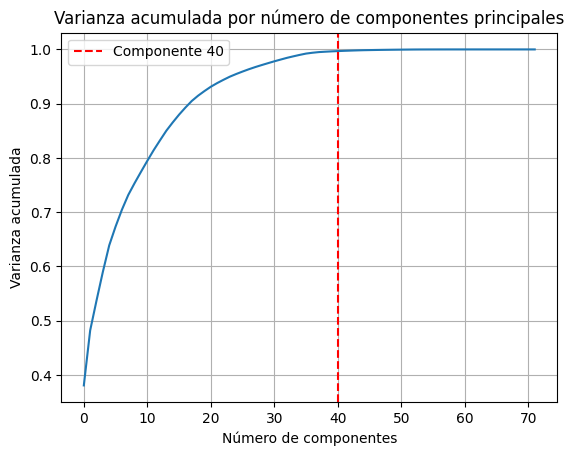

In [ ]:
pca_oliv = PCA(72)
X_proj = pca_oliv.fit_transform(X_resampled)
print(X_proj.shape)

cumvar = np.cumsum(pca_oliv.explained_variance_ratio_)
print(cumvar)
print(cumvar[40])

plt.plot(cumvar)
plt.axvline(x=40, color='r', linestyle='--', label='Componente 40')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada')
plt.title('Varianza acumulada por número de componentes principales')
plt.legend()
plt.grid(True)
plt.show()

Si se toma 40 como el número de componentes se consigue describir el 99.69% de la varianza acumulada. Por lo tanto, el número de columnas se reduce del 72 a solamente 40.

In [ ]:
pca=PCA(40)
X_pca_train=pca.fit_transform(X_resampled)
X_pca_sample=pca.fit_transform(X_sample)
X_pca_val=pca.transform(x_val_ml)
X_pca_test=pca.transform(x_test_ml)

## 7.1. KNN

In [ ]:
knn_model= KNeighborsClassifier()

RandomizedSearch

In [ ]:
param_dist = {"n_neighbors": [1, 3, 5, 11],
              "weights": ["uniform", "distance"],
              "algorithm": ["auto", "kd_tree"],
              "leaf_size": [ 30, 40],
              "p":[1,2],
              "metric": ["minkowski", "euclidean", "manhattan"]}

In [ ]:
rnd_knn= RandomizedSearchCV(estimator = knn_model, param_distributions = param_dist,
                               n_iter = 50, cv = 4, random_state=0, n_jobs = -1)
rnd_knn.fit(X_pca_sample, y_sample)

/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


RandomizedSearchCV(cv=4, estimator=KNeighborsClassifier(), n_iter=50, n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'kd_tree'],
                                        'leaf_size': [30, 40],
                                        'metric': ['minkowski', 'euclidean',
                                                   'manhattan'],
                                        'n_neighbors': [1, 3, 5, 11],
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   random_state=0)

In [ ]:
rnd_knn.best_params_

{'weights': 'distance',
 'p': 2,
 'n_neighbors': 3,
 'metric': 'euclidean',
 'leaf_size': 40,
 'algorithm': 'auto'}

GridSearch

In [ ]:
param_dist = {"n_neighbors": [1, 3, 5],
              "weights": ["distance"],
              "algorithm": ["auto"],
              "leaf_size": [ 30, 40, 50],
              "p":[1,2,3],
              "metric": ["euclidean"]}

In [ ]:
grid_knn = GridSearchCV(estimator=knn_model, param_grid=param_dist, cv=4, n_jobs=-1)
grid_knn.fit(X_pca_sample, y_sample)

/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


GridSearchCV(cv=4, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto'], 'leaf_size': [30, 40, 50],
                         'metric': ['euclidean'], 'n_neighbors': [1, 3, 5],
                         'p': [1, 2, 3], 'weights': ['distance']})

In [ ]:
grid_knn.best_params_

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'euclidean',
 'n_neighbors': 3,
 'p': 1,
 'weights': 'distance'}

KNeighborsClassifier(leaf_size=20, n_neighbors=3, p=1, weights='distance')

In [ ]:
knn=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean', n_neighbors=3, p=1, weights='distance')

Entrenar el modelo.

In [ ]:
knn.fit(X_pca_train, y_resampled['Label'])

KNeighborsClassifier(metric='euclidean', n_neighbors=3, p=1, weights='distance')

Predicciones de validación.

In [ ]:
y_pred_val_knn = knn.predict(X_pca_val)

In [ ]:
resultados(y_val, y_pred_val_knn)

Accuracy: 0.8594750320102432
Precision: 0.6788057742782152
Recall: 0.7663909124583282
F1-score: 0.7199443252334281
Confusion Matrix:
[[23328  2937]
 [ 1892  6207]]
Balanced Accuracy: 0.8272845481766227
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.91     26265
           1       0.68      0.77      0.72      8099

    accuracy                           0.86     34364
   macro avg       0.80      0.83      0.81     34364
weighted avg       0.87      0.86      0.86     34364



Predicciones del test.

In [ ]:
y_pred_knn = knn.predict(X_pca_test)

In [ ]:
resultados(y_test, y_pred_knn)

Accuracy: 0.8405934247077139
Precision: 0.6604827894501565
Recall: 0.7301704966641956
F1-score: 0.6935805656613073
Confusion Matrix:
[[21627  3038]
 [ 2184  5910]]
Balanced Accuracy: 0.8035000060860001
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89     24665
           1       0.66      0.73      0.69      8094

    accuracy                           0.84     32759
   macro avg       0.78      0.80      0.79     32759
weighted avg       0.85      0.84      0.84     32759



In [ ]:
id_test["y_pred_knn"] = y_pred_knn

In [ ]:
y_pred_knn_3=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_knn']
  y_pred_knn_3.append(tres_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_knn_3)

Accuracy: 0.7702127659574468
Precision: 0.6676923076923077
Recall: 1.0
F1-score: 0.8007380073800738
Confusion Matrix:
[[145 108]
 [  0 217]]
Balanced Accuracy: 0.7865612648221344
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       253
           1       0.67      1.00      0.80       217

    accuracy                           0.77       470
   macro avg       0.83      0.79      0.76       470
weighted avg       0.85      0.77      0.76       470



In [ ]:
y_pred_knn_6=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_knn']
  y_pred_knn_6.append(seis_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_knn_6)

Accuracy: 0.9042553191489362
Precision: 0.8359375
Recall: 0.9861751152073732
F1-score: 0.904862579281184
Confusion Matrix:
[[211  42]
 [  3 214]]
Balanced Accuracy: 0.9100836050345167
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.83      0.90       253
           1       0.84      0.99      0.90       217

    accuracy                           0.90       470
   macro avg       0.91      0.91      0.90       470
weighted avg       0.92      0.90      0.90       470



In [ ]:
y_pred_knn_8=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_knn']
  y_pred_knn_8.append(ocho_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_knn_8)

Accuracy: 0.9085106382978724
Precision: 0.875
Recall: 0.9354838709677419
F1-score: 0.9042316258351893
Confusion Matrix:
[[224  29]
 [ 14 203]]
Balanced Accuracy: 0.910429682519444
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.91       253
           1       0.88      0.94      0.90       217

    accuracy                           0.91       470
   macro avg       0.91      0.91      0.91       470
weighted avg       0.91      0.91      0.91       470



In [ ]:
y_pred_knn_10=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_knn']
  y_pred_knn_10.append(diez_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_knn_10)

Accuracy: 0.874468085106383
Precision: 0.898989898989899
Recall: 0.8202764976958525
F1-score: 0.8578313253012049
Confusion Matrix:
[[233  20]
 [ 39 178]]
Balanced Accuracy: 0.8706125571483215
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       253
           1       0.90      0.82      0.86       217

    accuracy                           0.87       470
   macro avg       0.88      0.87      0.87       470
weighted avg       0.88      0.87      0.87       470



In [ ]:
y_pred_knn_12=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_knn']
  y_pred_knn_12.append(doce_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_knn_12)

Accuracy: 0.8531914893617021
Precision: 0.9111111111111111
Recall: 0.7557603686635944
F1-score: 0.8261964735516373
Confusion Matrix:
[[237  16]
 [ 53 164]]
Balanced Accuracy: 0.8462596309721134
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.94      0.87       253
           1       0.91      0.76      0.83       217

    accuracy                           0.85       470
   macro avg       0.86      0.85      0.85       470
weighted avg       0.86      0.85      0.85       470



ROC

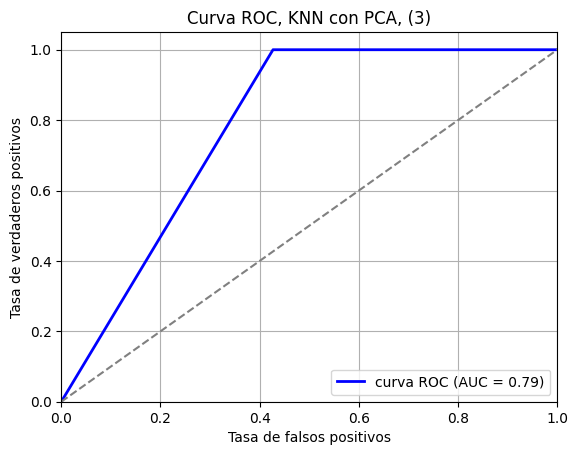

In [ ]:
fpr, tpr, thresholds=roc_curve(y_test_true, y_pred_knn_3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC, KNN con PCA, (3)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## 7.2. SVC

Randomized Search

In [ ]:
svc= SVC()

In [ ]:
param_dist = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf", "poly"],
    "gamma": [0.1, 1, 'scale', 'auto'],
    "shrinking": [True, False]
}

In [ ]:
rnd_svc= RandomizedSearchCV(estimator =svc, param_distributions = param_dist, cv=4, n_iter=50, random_state=0, n_jobs = -1)
rnd_svc.fit(X_pca_sample, y_sample)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=4, estimator=SVC(), n_iter=50, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10],
                                        'gamma': [0.1, 1, 'scale', 'auto'],
                                        'kernel': ['linear', 'rbf', 'poly'],
                                        'shrinking': [True, False]},
                   random_state=0)

In [ ]:
rnd_svc.best_params_

{'shrinking': False, 'kernel': 'rbf', 'gamma': 'auto', 'C': 10}


rnd_svc.best_params_
{'shrinking': False, 'kernel': 'rbf', 'gamma': 'auto', 'C': 10}

Grid Search

In [ ]:
param_dist = {
    "C": [5, 10, 50, 100],
    "kernel": ["rbf"],
    "gamma": ['auto'],
    "shrinking": [False]
}

In [ ]:
grid_svc = GridSearchCV(estimator = svc, param_grid= param_dist, cv=4, n_jobs=-1)
grid_svc.fit(X_pca_sample, np.array(y_sample['Label']))

GridSearchCV(cv=4, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [5, 10, 50, 100], 'gamma': ['auto'],
                         'kernel': ['rbf'], 'shrinking': [False]})

In [ ]:
grid_svc.best_estimator_

SVC(C=10, gamma='auto', shrinking=False)

SVC(C=10, gamma='auto', shrinking=False)

In [ ]:
svc = SVC(C=10, gamma='auto', shrinking=False)

In [ ]:
svc.fit(X_pca_train, y_resampled['Label'])

SVC(C=10, gamma='auto', shrinking=False)

Realizar las predicciones

Validación

In [ ]:
y_pred_val_svc=svc.predict(X_pca_val)

In [ ]:
resultados(y_val, y_pred_val_svc)

Accuracy: 0.7048073565359096
Precision: 0.4332702473405991
Recall: 0.819730830966786
F1-score: 0.566902911792332
Confusion Matrix:
[[17581  8684]
 [ 1460  6639]]
Balanced Accuracy: 0.7445503574213332
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.67      0.78     26265
           1       0.43      0.82      0.57      8099

    accuracy                           0.70     34364
   macro avg       0.68      0.74      0.67     34364
weighted avg       0.81      0.70      0.73     34364



Test

In [ ]:
y_pred_svc=svc.predict(X_pca_test)

In [ ]:
resultados(y_test, y_pred_svc)

Accuracy: 0.7381177691626728
Precision: 0.4825376251170159
Recall: 0.827897207808253
F1-score: 0.6097083845138984
Confusion Matrix:
[[17479  7186]
 [ 1393  6701]]
Balanced Accuracy: 0.7682765990389329
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.71      0.80     24665
           1       0.48      0.83      0.61      8094

    accuracy                           0.74     32759
   macro avg       0.70      0.77      0.71     32759
weighted avg       0.82      0.74      0.76     32759



In [ ]:
id_test["y_pred_svc"] = y_pred_svc

In [ ]:
y_pred_svc_3=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_svc']
  y_pred_svc_3.append(tres_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_svc_3)

Accuracy: 0.548936170212766
Precision: 0.5058275058275058
Recall: 1.0
F1-score: 0.6718266253869969
Confusion Matrix:
[[ 41 212]
 [  0 217]]
Balanced Accuracy: 0.5810276679841897
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.16      0.28       253
           1       0.51      1.00      0.67       217

    accuracy                           0.55       470
   macro avg       0.75      0.58      0.48       470
weighted avg       0.77      0.55      0.46       470



In [ ]:
y_pred_svc_6=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_svc']
  y_pred_svc_6.append(seis_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_svc_6)

Accuracy: 0.7063829787234043
Precision: 0.6112676056338028
Recall: 1.0
F1-score: 0.7587412587412588
Confusion Matrix:
[[115 138]
 [  0 217]]
Balanced Accuracy: 0.7272727272727273
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.45      0.62       253
           1       0.61      1.00      0.76       217

    accuracy                           0.71       470
   macro avg       0.81      0.73      0.69       470
weighted avg       0.82      0.71      0.69       470



In [ ]:
y_pred_svc_8=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_svc']
  y_pred_svc_8.append(ocho_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_svc_8)

Accuracy: 0.8063829787234043
Precision: 0.7045454545454546
Recall: 1.0
F1-score: 0.8266666666666667
Confusion Matrix:
[[162  91]
 [  0 217]]
Balanced Accuracy: 0.8201581027667983
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.64      0.78       253
           1       0.70      1.00      0.83       217

    accuracy                           0.81       470
   macro avg       0.85      0.82      0.80       470
weighted avg       0.86      0.81      0.80       470



In [ ]:
y_pred_svc_10=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_svc']
  y_pred_svc_10.append(diez_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_svc_10)

Accuracy: 0.8382978723404255
Precision: 0.7439446366782007
Recall: 0.9907834101382489
F1-score: 0.849802371541502
Confusion Matrix:
[[179  74]
 [  2 215]]
Balanced Accuracy: 0.849146645780587
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.71      0.82       253
           1       0.74      0.99      0.85       217

    accuracy                           0.84       470
   macro avg       0.87      0.85      0.84       470
weighted avg       0.88      0.84      0.84       470



In [ ]:
y_pred_svc_12=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_svc']
  y_pred_svc_12.append(doce_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_svc_12)

Accuracy: 0.8531914893617021
Precision: 0.7936507936507936
Recall: 0.9216589861751152
F1-score: 0.8528784648187633
Confusion Matrix:
[[201  52]
 [ 17 200]]
Balanced Accuracy: 0.8580626946685852
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.79      0.85       253
           1       0.79      0.92      0.85       217

    accuracy                           0.85       470
   macro avg       0.86      0.86      0.85       470
weighted avg       0.86      0.85      0.85       470



Curva ROC del umbral 8

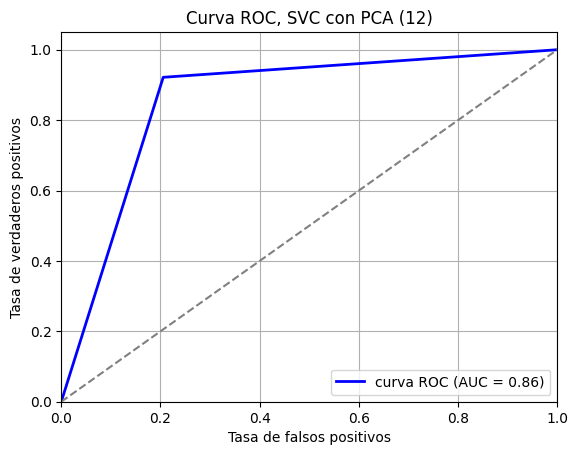

In [ ]:
fpr, tpr, thresholds=roc_curve(y_test_true, y_pred_svc_12)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC, SVC con PCA (12)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## 7.3. Random Forest

In [ ]:
RF =  RandomForestRegressor()

RandomizedSearch

In [ ]:
param_dist = {"n_estimators": [4, 16, 32],
              "max_features": [1.0, "sqrt"],
              "max_depth": [16, 12, 4, 2,None],
              "min_samples_split": sp_randint(2, 30),
              "min_samples_leaf": sp_randint(1, 30),
              "bootstrap": [True, False],
              "criterion": ["squared_error", "absolute_error"]}

In [ ]:
rnd_rf = RandomizedSearchCV(estimator = RF, param_distributions = param_dist, n_iter = 50, cv = 4, random_state=0, n_jobs = -1)
rnd_rf.fit(X_pca_sample, y_sample)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomizedSearchCV(cv=4, estimator=RandomForestRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['squared_error',
                                                      'absolute_error'],
                                        'max_depth': [16, 12, 4, 2, None],
                                        'max_features': [1.0, 'sqrt'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7be6e0e62d50>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7be6e1843a90>,
                                        'n_estimators': [4, 16, 32]},
                   random_state=0)

In [ ]:
rnd_rf.best_params_

{'bootstrap': True,
 'criterion': 'squared_error',
 'max_depth': 16,
 'max_features': 1.0,
 'min_samples_leaf': 20,
 'min_samples_split': 16,
 'n_estimators': 32}

{'bootstrap': True,
 'criterion': 'squared_error',
 'max_depth': 16,
 'max_features': 1.0,
 'min_samples_leaf': 20,
 'min_samples_split': 16,
 'n_estimators': 32}

GridSearch

In [ ]:
param_dist = {"n_estimators": [ 16, 32, 40],
              "max_features": [1.0],
              "max_depth": [20, 16, 8],
              "min_samples_split": [10, 20, 30],
              "min_samples_leaf": [10, 20, 30] ,
              "bootstrap": [True],
              "criterion": ["squared_error"]}

In [ ]:
grid_rf = GridSearchCV(estimator = RF, param_grid= param_dist, cv=4, n_jobs=-1)
grid_rf.fit(X_pca_sample, np.array(y_sample['Label']))

GridSearchCV(cv=4, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'criterion': ['squared_error'],
                         'max_depth': [20, 16, 8], 'max_features': [1.0],
                         'min_samples_leaf': [10, 20, 30],
                         'min_samples_split': [10, 20, 30],
                         'n_estimators': [16, 32, 40]})

In [ ]:
grid_rf.best_params_

{'bootstrap': True,
 'criterion': 'squared_error',
 'max_depth': 16,
 'max_features': 1.0,
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 32}


grid_rf.best_params_
{'bootstrap': True,
 'criterion': 'squared_error',
 'max_depth': 16,
 'max_features': 1.0,
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 32}

Entrenar el modelo.

In [ ]:
rf=RandomForestRegressor(n_estimators=32, max_features=1.0, max_depth= 16, min_samples_split= 10, min_samples_leaf= 10, bootstrap= True, criterion='squared_error')
rf.fit(X_pca_train, y_resampled['Label'])

RandomForestRegressor(max_depth=16, min_samples_leaf=10, min_samples_split=10,
                      n_estimators=32)

Predicciones de la validación.

In [ ]:
y_pred_val_rf=(rf.predict(X_pca_val) > 0.5).astype("int32").ravel()
resultados(y_val, y_pred_val_rf)

Accuracy: 0.8850541264113607
Precision: 0.7298614958448754
Recall: 0.8133102852203976
F1-score: 0.769329595888811
Confusion Matrix:
[[23827  2438]
 [ 1512  6587]]
Balanced Accuracy: 0.8602435682717255
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.92     26265
           1       0.73      0.81      0.77      8099

    accuracy                           0.89     34364
   macro avg       0.84      0.86      0.85     34364
weighted avg       0.89      0.89      0.89     34364



Predicciones del test.

In [ ]:
y_pred_rf=(rf.predict(X_pca_test) > 0.5).astype("int32").ravel()
resultados(y_test, y_pred_rf)

Accuracy: 0.8789950853200648
Precision: 0.7213765008576329
Recall: 0.8313565604151223
F1-score: 0.7724715876478017
Confusion Matrix:
[[22066  2599]
 [ 1365  6729]]
Balanced Accuracy: 0.8629922879107843
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.92     24665
           1       0.72      0.83      0.77      8094

    accuracy                           0.88     32759
   macro avg       0.83      0.86      0.85     32759
weighted avg       0.89      0.88      0.88     32759



In [ ]:
id_test["y_pred_rf"] = y_pred_rf

In [ ]:
y_pred_rf_3=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_rf']
  y_pred_rf_3.append(tres_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_rf_3)

Accuracy: 0.7638297872340426
Precision: 0.6615853658536586
Recall: 1.0
F1-score: 0.7963302752293578
Confusion Matrix:
[[142 111]
 [  0 217]]
Balanced Accuracy: 0.7806324110671936
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.56      0.72       253
           1       0.66      1.00      0.80       217

    accuracy                           0.76       470
   macro avg       0.83      0.78      0.76       470
weighted avg       0.84      0.76      0.75       470



In [ ]:
y_pred_rf_6=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_rf']
  y_pred_rf_6.append(seis_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_rf_6)

Accuracy: 0.8702127659574468
Precision: 0.782608695652174
Recall: 0.9953917050691244
F1-score: 0.8762677484787018
Confusion Matrix:
[[193  60]
 [  1 216]]
Balanced Accuracy: 0.8791187774357481
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.76      0.86       253
           1       0.78      1.00      0.88       217

    accuracy                           0.87       470
   macro avg       0.89      0.88      0.87       470
weighted avg       0.90      0.87      0.87       470



In [ ]:
y_pred_rf_8=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_rf']
  y_pred_rf_8.append(ocho_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_rf_8)

Accuracy: 0.9106382978723404
Precision: 0.8514056224899599
Recall: 0.9769585253456221
F1-score: 0.9098712446351931
Confusion Matrix:
[[216  37]
 [  5 212]]
Balanced Accuracy: 0.9153567330285423
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       253
           1       0.85      0.98      0.91       217

    accuracy                           0.91       470
   macro avg       0.91      0.92      0.91       470
weighted avg       0.92      0.91      0.91       470



In [ ]:
y_pred_rf_10=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_rf']
  y_pred_rf_10.append(diez_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_rf_10)

Accuracy: 0.9042553191489362
Precision: 0.864406779661017
Recall: 0.9400921658986175
F1-score: 0.9006622516556292
Confusion Matrix:
[[221  32]
 [ 13 204]]
Balanced Accuracy: 0.9068049762299412
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.87      0.91       253
           1       0.86      0.94      0.90       217

    accuracy                           0.90       470
   macro avg       0.90      0.91      0.90       470
weighted avg       0.91      0.90      0.90       470



In [ ]:
y_pred_rf_12=[]
for id in id_test['ID'].unique():
  y_id=id_test[id_test['ID']==id]['y_pred_rf']
  y_pred_rf_12.append(doce_seguidas(y_id))

In [ ]:
resultados(y_test_true, y_pred_rf_12)

Accuracy: 0.9
Precision: 0.8828828828828829
Recall: 0.9032258064516129
F1-score: 0.8929384965831435
Confusion Matrix:
[[227  26]
 [ 21 196]]
Balanced Accuracy: 0.9002295040163203
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       253
           1       0.88      0.90      0.89       217

    accuracy                           0.90       470
   macro avg       0.90      0.90      0.90       470
weighted avg       0.90      0.90      0.90       470

